In [52]:
# Libraries
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as data
import seaborn as sns
import datetime
import json
from yahoofinancials import YahooFinancials
from selenium import webdriver
from selenium.webdriver.chrome.webdriver import WebDriver
from webdriver_manager.chrome import ChromeDriverManager
import re
import requests
import warnings

driver = webdriver.Chrome()

asset_dict = {} 

warnings.filterwarnings('ignore')


def get_table(soup):
    for t in soup.select('table'):
        header = t.select('thead tr th')
        if len(header) > 2:
            if (header[0].get_text().strip() == 'Symbol'
                and header[2].get_text().strip().startswith('% Holding')):
                return t
    raise Exception('could not find symbol list table')
    
# Scrapes ETF holdings from barchart.com
def get_etf_holdings():
    '''
    etf_symbol: str
    
    return: pd.DataFrame
    '''
    url = 'https://www.barchart.com/stocks/quotes/VONE/constituents?page=all'

    # Loads the ETF constituents page and reads the holdings table
    browser = WebDriver() # webdriver.PhantomJS()
    browser.get(url)
    html = browser.page_source
    soup = BeautifulSoup(html, 'html')
    table = get_table(soup)

    # Reads the holdings table line by line and appends each asset to a
    # dictionary along with the holdings percentage
    for row in table.select('tr')[1:26]:
        try:
            cells = row.select('td')
            # print(row)
            symbol = cells[0].get_text().strip()
            # print(symbol)
            # name = cells[1].text.strip()
            celltext = cells[2].get_text().strip()
            percent = float(celltext.rstrip('%'))
            # shares = int(cells[3].text.strip().replace(',', ''))
            if symbol != "" and percent != 0.0:
                asset_dict[symbol] = {
                    'percent': percent,
                }
        except BaseException as ex:
            print(ex)
    browser.quit()
    return pd.DataFrame(asset_dict)

constituent = get_etf_holdings()

constituent.T

# Assets
russell_index = ["^RUI"]
tickers = []

# Set timeframe
start = "2019-03-31"
end = "2019-04-29"


def pullTickers():

    list(asset_dict.keys())

    for key in asset_dict.keys():
        tickers.append(key.replace('.','-'))
    return tickers


pullTickers()



['AAPL',
 'MSFT',
 'AMZN',
 'FB',
 'BRK-B',
 'JPM',
 'GOOG',
 'GOOGL',
 'JNJ',
 'V',
 'PG',
 'XOM',
 'BAC',
 'T',
 'UNH',
 'MA',
 'INTC',
 'VZ',
 'DIS',
 'HD',
 'MRK',
 'CVX',
 'PFE',
 'KO',
 'CSCO']

In [2]:
marketCaps = {}

def pullFundamentals():

    for i in tickers:
        yahoo_financials = YahooFinancials(i)
        sharesOutstanding = yahoo_financials.get_key_statistics_data()[i]['sharesOutstanding']
        
        prices = yahoo_financials.get_historical_price_data('2019-04-01', '2019-04-02', 'daily')[i]['prices'][0]['adjclose']

        mcap = sharesOutstanding * prices

        marketCaps[i] = mcap
        
        print(marketCaps)

pullFundamentals()

{'AAPL': 829533959525.7891}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469, 'AMZN': 899469915865.875}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469, 'AMZN': 899469915865.875, 'FB': 405971462761.6367}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0, 'JPM': 313468157958.9844}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0, 'JPM': 313468157958.9844, 'GOOG': 410347648937.8867}
{'AAPL': 829533959525.7891, 'MSFT': 895891485166.0469, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0, 'JPM': 313468157958.9844, 'GOOG': 410347648937.8867, 'GOOGL': 359247973587.8906}
{'AAPL': 829533959525.7891, 'MSFT': 8958914851

In [3]:
replicatedWeights = {}

aggregateValue = sum(marketCaps.values())    

for i in tickers:
    weights = marketCaps[i] / aggregateValue

    replicatedWeights[i] = weights

    print(replicatedWeights)

{'AAPL': 0.09755944658273906}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373, 'AMZN': 0.1057844422184497}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373, 'AMZN': 0.1057844422184497, 'FB': 0.0477453041923102}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373, 'AMZN': 0.1057844422184497, 'FB': 0.0477453041923102, 'BRK-B': 0.033353627887715}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373, 'AMZN': 0.1057844422184497, 'FB': 0.0477453041923102, 'BRK-B': 0.033353627887715, 'JPM': 0.036866218267027316}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373, 'AMZN': 0.1057844422184497, 'FB': 0.0477453041923102, 'BRK-B': 0.033353627887715, 'JPM': 0.036866218267027316, 'GOOG': 0.04825997667388292}
{'AAPL': 0.09755944658273906, 'MSFT': 0.10536359179430373, 'AMZN': 0.1057844422184497, 'FB': 0.0477453041923102, 'BRK-B': 0.033353627887715, 'JPM': 0.036866218267027316, 'GOOG': 0.04825997667388292, 'G

In [4]:
rweights = list(replicatedWeights.values())

print(rweights)

[0.09755944658273906, 0.10536359179430373, 0.1057844422184497, 0.0477453041923102, 0.033353627887715, 0.036866218267027316, 0.04825997667388292, 0.04225026966857464, 0.04211624762221858, 0.031513462394001296, 0.02933371051216447, 0.03924175136901697, 0.029147026008130773, 0.025426849440522706, 0.027006542949200657, 0.0278981692695568, 0.027380601327174514, 0.027575237769674493, 0.023598838519988084, 0.024615087491430297, 0.024445548051599042, 0.02696784461050712, 0.026844993072321462, 0.0230178299676216, 0.026687382339868577]


In [5]:

def replicateETF():
    prices = data.DataReader(tickers, data_source="yahoo", start=start, end=end)['Adj Close']
    x = 0
    for i in tickers:
        prices[i] *= rweights[x]
        x += 1

    prices['ETF'] = prices.sum(axis = 1)
    
    return prices['ETF']

replicateETF()


Date
2019-04-01    400.435768
2019-04-02    401.383996
2019-04-03    402.897599
2019-04-04    403.666081
2019-04-05    405.277790
2019-04-08    406.703859
2019-04-09    404.447712
2019-04-10    406.264511
2019-04-11    405.800461
2019-04-12    407.395626
2019-04-15    408.216290
2019-04-16    410.522076
2019-04-17    411.967388
2019-04-18    411.904145
2019-04-22    416.295554
2019-04-23    422.541246
2019-04-24    419.066587
2019-04-25    420.615308
2019-04-26    426.761648
2019-04-29    427.268842
2019-04-30    417.096892
Name: ETF, dtype: float64

In [6]:
etfReturn = replicateETF().pct_change()[1:]


print(etfReturn)

Date
2019-04-02    0.002368
2019-04-03    0.003771
2019-04-04    0.001907
2019-04-05    0.003993
2019-04-08    0.003519
2019-04-09   -0.005547
2019-04-10    0.004492
2019-04-11   -0.001142
2019-04-12    0.003931
2019-04-15    0.002014
2019-04-16    0.005648
2019-04-17    0.003521
2019-04-18   -0.000154
2019-04-22    0.010661
2019-04-23    0.015003
2019-04-24   -0.008223
2019-04-25    0.003696
2019-04-26    0.014613
2019-04-29    0.001188
2019-04-30   -0.023807
Name: ETF, dtype: float64


In [7]:
etfTotalReturn = etfReturn.values

print(etfTotalReturn)

[ 0.00236799  0.00377096  0.00190739  0.00399268  0.00351875 -0.0055474
  0.00449205 -0.00114224  0.00393091  0.00201442  0.00564844  0.00352067
 -0.00015351  0.01066124  0.01500302 -0.00822324  0.00369564  0.01461273
  0.00118847 -0.02380691]


In [8]:
def russell():
    # Pull data from Yahoo! Finance for Russell 1000 Index
    df = data.DataReader(russell_index, data_source="yahoo", start=start, end=end)

    #percentage = df["Adj Close"].pct_change()
    #russellReturn = percentage[1:]    

    return df["Adj Close"]


russell()

Symbols,^RUI
Date,
2019-04-01,1588.650024
2019-04-02,1588.569946
2019-04-03,1592.479980
2019-04-04,1595.109985
2019-04-05,1602.880005
2019-04-08,1604.560059
2019-04-09,1594.420044
2019-04-10,1600.930054
2019-04-11,1601.270020


In [9]:
russellReturn = russell().pct_change()[1:]


russellTotalReturn = russellReturn.values.flatten()


print(russellTotalReturn)

[-5.04063977e-05  2.46135475e-03  1.65151519e-03  4.87114970e-03
  1.04814690e-03 -6.31949835e-03  4.08299544e-03  2.12355199e-04
  6.67591429e-03 -7.07222683e-04  3.22829086e-04 -2.99126590e-03
  1.50015820e-03  8.32830375e-04  9.20339205e-03 -1.95677268e-03
 -8.69366457e-04  2.85096891e-03  3.24900888e-03  9.01601252e-04]


In [10]:

def trackingError():

    returnDifference = etfTotalReturn - russellTotalReturn
    
    squaredValues = returnDifference ** 2

    sumation = squaredValues.sum()

    Error = (sumation / (20 - 1)) ** (1/2)


    print("Tracking Error is " + "{:.2%}".format(Error))


trackingError()






Tracking Error is 0.74%


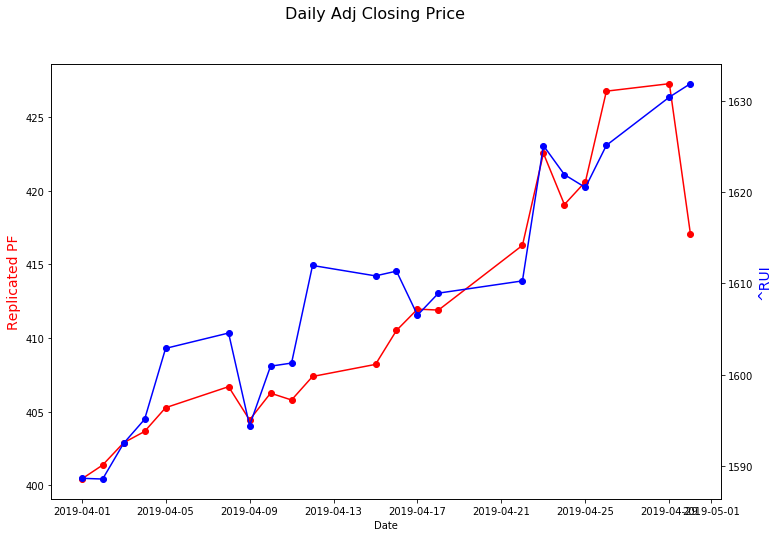

In [41]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
fig.suptitle('Daily Adj Closing Price', fontsize=16)
plt.rcParams['figure.figsize'] = (12,8)
ax.plot(figsize = (12,8))
ax2.plot(figsize = (12,8))
ax.plot(replicateETF(), color="red", marker="o")
# set x-axis label
ax.set_xlabel("Date")
# set y-axis label
ax.set_ylabel("Replicated PF",color="red",fontsize=14)

ax2=ax.twinx()




ax2.plot(russell(), color="blue", marker="o")
ax2.set_ylabel("^RUI",color="blue",fontsize=14)
plt.show()





Text(0.5, 0, 'Days')

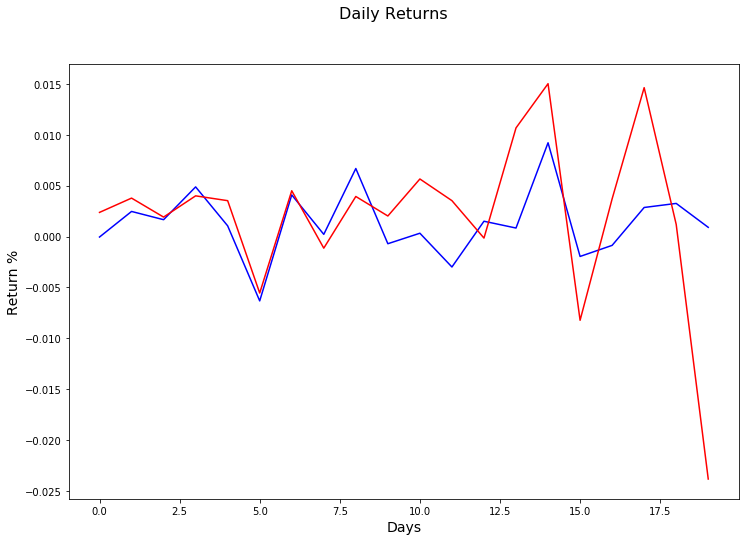

In [51]:
fig=plt.figure(figsize = (12,8))
fig.suptitle('Daily Returns', fontsize=16)

fig.show()
ax=fig.add_subplot(111)

plt.plot(russellTotalReturn, color="blue")
plt.plot(etfTotalReturn, color="red")

ax.set_ylabel("Return %",fontsize=14)
ax.set_xlabel("Days",fontsize=14)